In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", names=['sentiment', 'ids', 'date', 'flag', 'user', 'text'], encoding="ISO-8859-1")

In [6]:
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
emojis_dic = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [8]:
def remove_urls_mentions(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    return text

def tokenize_text(text):
    return word_tokenize(text)

def remove_stop_words(words):
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    return words

def perform_lemmatization(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def remove_punctuations_numbers(words):
    return [word for word in words if word.isalpha()]

def emojis_encode(text):
    if isinstance(text, list):
        # If the input is a list of words, apply emoji encoding to each word
        return [emojis_dic.get(word, word) for word in text]
    elif isinstance(text, str):
        # If the input is a string, apply emoji encoding to the entire string
        for emoji, replacement in emojis_dic.items():
            text = text.replace(emoji, "EMOJI" + replacement)
        return text
    else:
        # If the input is neither a list nor a string, return it unchanged
        return text


def replace_consecutive_letters(text):
    if isinstance(text, list):
        # If the input is a list of words, join the words into a string
        text = ' '.join(text)
    
    # Use regular expression to replace 3 or more consecutive letters with 2 letters
    return re.sub(r'(\w)\1{2,}', r'\1\1', text)

def remove_short_words(text):
    # Remove words with length less than 2
    words = text.split()
    return ' '.join([word for word in words if len(word) > 1])


def preprocess_data(df):
    df['preprocessed_text'] = df['text'].apply(remove_urls_mentions)
    df['preprocessed_text'] = df['preprocessed_text'].apply(tokenize_text)
    df['preprocessed_text'] = df['preprocessed_text'].apply(remove_stop_words)
    df['preprocessed_text'] = df['preprocessed_text'].apply(perform_lemmatization)
    df['preprocessed_text'] = df['preprocessed_text'].apply(remove_punctuations_numbers)
    df['preprocessed_text'] = df['preprocessed_text'].apply(emojis_encode)
    df['preprocessed_text'] = df['preprocessed_text'].apply(replace_consecutive_letters)
    df['preprocessed_text'] = df['preprocessed_text'].apply(remove_short_words)
    return df

In [9]:
df_preprocessed = preprocess_data(df)
print(df_preprocessed['preprocessed_text'])

0                Aww bummer shoulda got David Carr Third Day
1          upset ca update Facebook texting might cry res...
2            dived many time ball Managed save rest go bound
3                            whole body feel itchy like fire
4                                        behaving mad ca see
                                 ...                        
1599995                        woke school best feeling ever
1599996                         cool hear old Walt interview
1599997                       ready MoJo Makeover Ask detail
1599998       Happy Birthday boo all time Tupac Amaru Shakur
1599999                                 happy charitytuesday
Name: preprocessed_text, Length: 1600000, dtype: object


In [10]:
print(df_preprocessed)

         sentiment         ids                          date      flag  \
0                0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1                0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2                0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3                0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4                0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...            ...         ...                           ...       ...   
1599995          4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996          4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997          4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998          4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999          4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  \
0        _TheSpecialOne_  @switc

In [11]:
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title)
    plt.show()



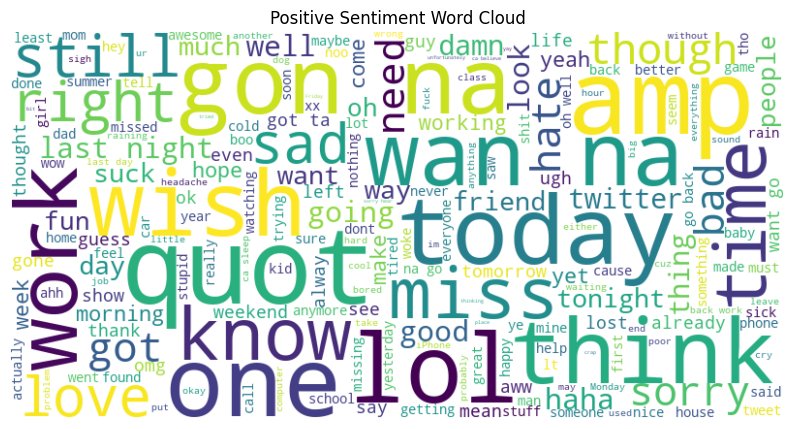

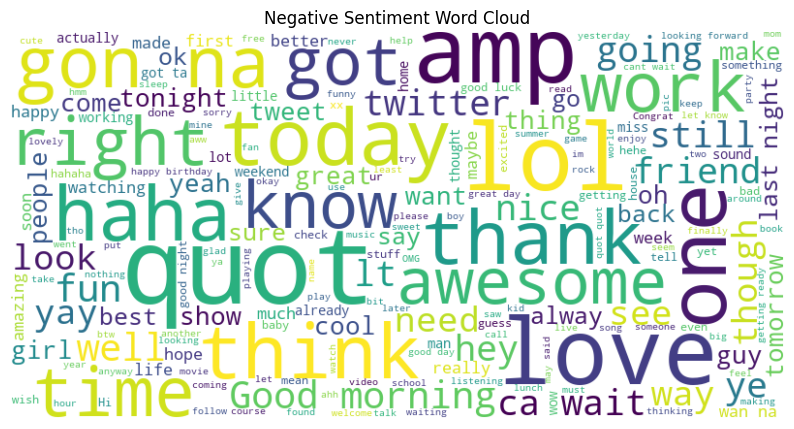

In [12]:
positive_text = ' '.join(df_preprocessed[df_preprocessed['sentiment'] == 0]['preprocessed_text'].explode().dropna())
negative_text = ' '.join(df_preprocessed[df_preprocessed['sentiment'] == 4]['preprocessed_text'].explode().dropna())

generate_word_cloud(positive_text, 'Positive Sentiment Word Cloud')
generate_word_cloud(negative_text, 'Negative Sentiment Word Cloud')

In [13]:
df_timeseries = df_preprocessed

In [14]:
df_preprocessed = df_preprocessed.drop(['ids', 'date', 'flag', 'user', 'text'], axis=1)

In [15]:
df_timeseries['date'] = pd.to_datetime(df_timeseries['date'])


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [16]:
df_timeseries.set_index('date', inplace=True)

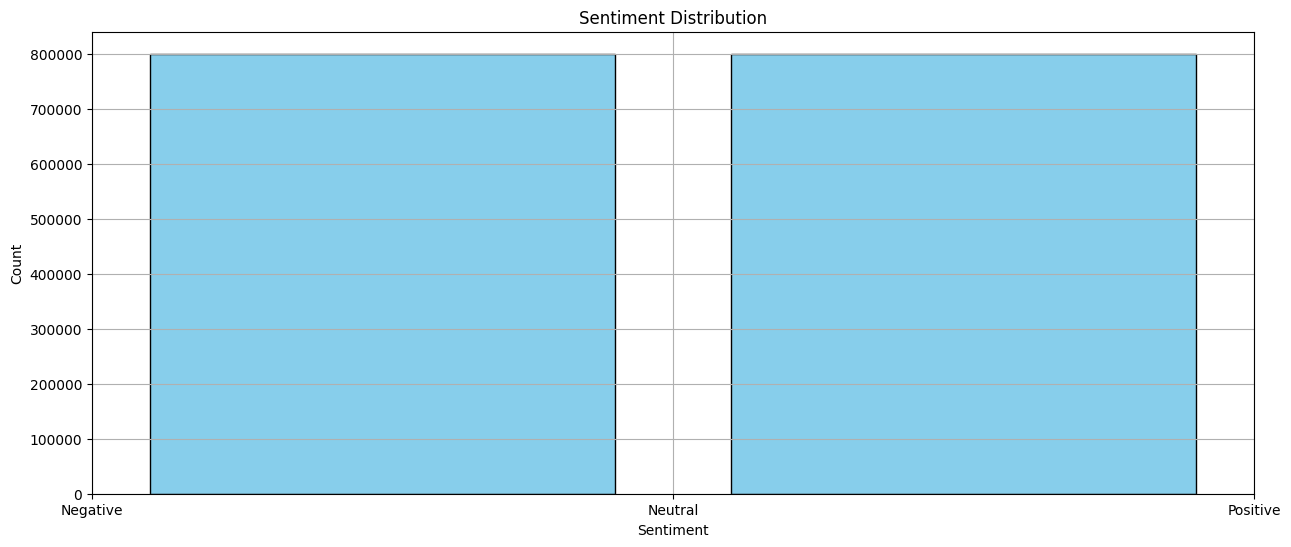

In [17]:
plt.figure(figsize=(15, 6))
df_timeseries['sentiment'].hist(bins=[0, 2, 4], rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 2, 4], ['Negative', 'Neutral', 'Positive'])
plt.show()

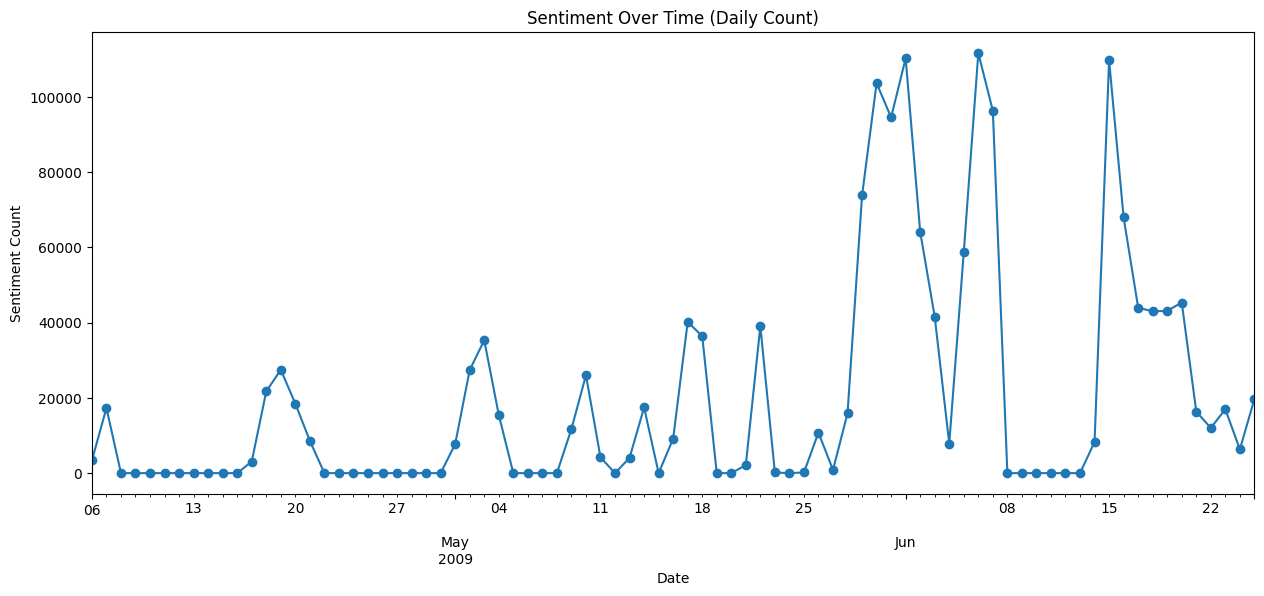

In [18]:
df_resampled = df_timeseries['sentiment'].resample('D').count()

plt.figure(figsize=(15, 6))
df_resampled.plot(style='o-', title='Sentiment Over Time (Daily Count)')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.show()

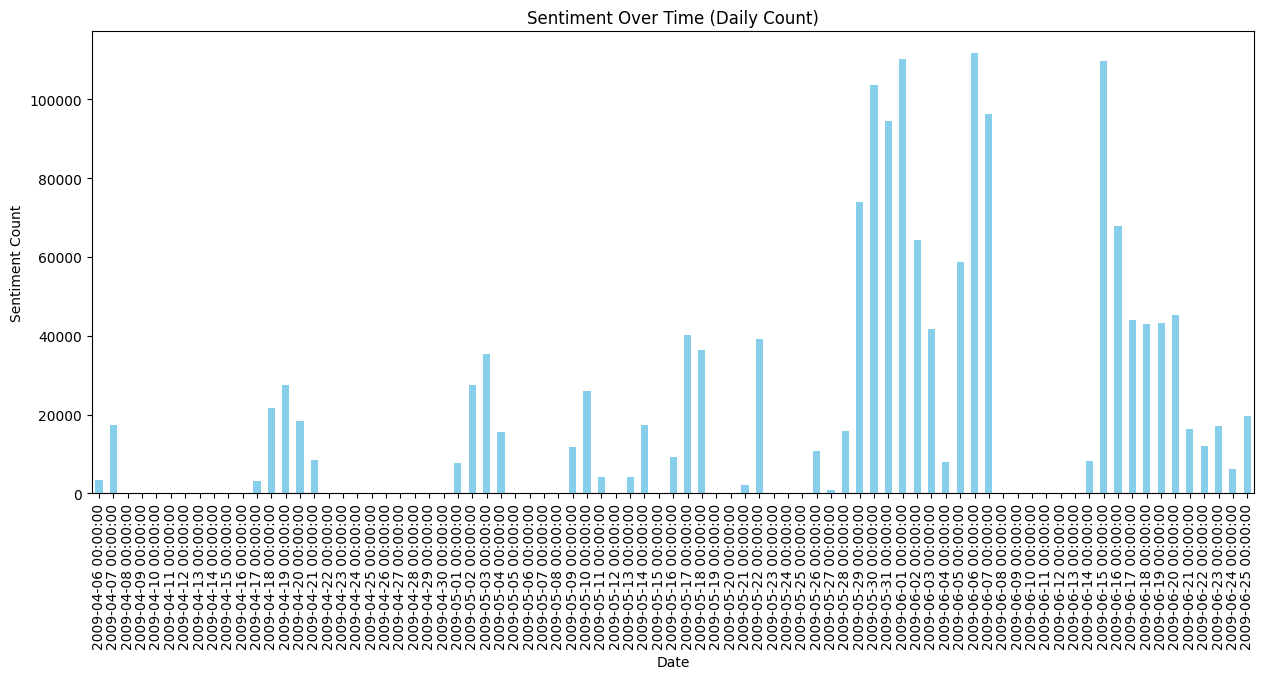

In [19]:
# Plotting histogram
plt.figure(figsize=(15, 6))
df_resampled.plot(kind='bar', color='skyblue', title='Sentiment Over Time (Daily Count)')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_preprocessed['preprocessed_text'], df_preprocessed['sentiment'],
                                                    test_size = 0.05, random_state = 42)

In [21]:
tfidfvc = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
tfidfvc.fit(X_train)


TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [22]:
X_train = tfidfvc.transform(X_train)
X_test  = tfidfvc.transform(X_test)

In [23]:
# Naive Bayes
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
nb_predictions = naive_bayes.predict(X_test)

print("Naive Bayes:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("Classification Report:\n", classification_report(y_test, nb_predictions))

Naive Bayes:
Accuracy: 0.7797625
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78     39999
           4       0.78      0.78      0.78     40001

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



In [24]:
# Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
lr_predictions = logistic_regression.predict(X_test)

print("\nLogistic Regression:")
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print("Classification Report:\n", classification_report(y_test, lr_predictions))


Logistic Regression:
Accuracy: 0.7962125
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79     39999
           4       0.79      0.81      0.80     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000, solver='saga'))
pipe.fit(X_train, y_train)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, solver='saga'))])

In [30]:
pipe.score(X_test, y_test)

0.7301